In [1]:
%run ../../../../../../../../recidiviz-research/utils/research_utils.py
adjust_plot_scale(0.4)
from IPython.display import display, HTML
from functools import partial

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../../../.."))
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    transitions_interpolation,
)
from recidiviz.utils.yaml_dict import YAMLDict

In [12]:
FED_DIRECTORY_PATH = "../../../state/FED/"
SENTENCING_DATA_PATH = FED_DIRECTORY_PATH + "sentencing_data/"

# Data dictionary:
# https://www.ussc.gov/sites/default/files/pdf/research-and-publications/datafiles/USSC_Public_Release_Codebook_FY99_FY20.pdf
common_columns = [
    # Total prison sentence months
    "TOTPRISN",
    # Month sentenced
    "SENTMON",
    # Year sentenced
    "SENTYR",
    # Primary drug type on the sentence
    "COMBDRG2",
    # Type of sentence imposed (prison, prison + fines, probation, probation + fines, just fines)
    "SENTIMP",
    # 1-5 Statutes on the sentences
    "NWSTAT1",
    "NWSTAT2",
    "NWSTAT3",
    "NWSTAT4",
    "NWSTAT5",
    # Sentencing district
    "DISTRICT",
    # Mandatory minimum
    "DRUGMIN",
    # The gram amount for the 1st drug type on the sentence
    "WGT1",
    # Race and ethnicity
    "NEWRACE",
]

new_data_columns = common_columns + [
    "OFFGUIDE",
]
old_data_columns = common_columns + [
    "OFFTYPSB",
]

# Supply some of the column types to silence warnings & process the large CSVs faster
column_dtypes = {
    "NWSTAT1": str,
    "NWSTAT2": str,
    "NWSTAT3": str,
    "NWSTAT4": str,
    "NWSTAT5": str,
}

new_data_files = [
    "opafy21nid.csv",
    "opafy20nid.csv",
    "opafy19nid.csv",
    "opafy18nid.csv",
]
# FY10-FY17 use the old offense type format
old_data_files = [f"opafy{year:02}nid.csv" for year in range(10, 18)]


def get_eligible_sentences(df: pd.DataFrame) -> pd.DataFrame:
    """Return only the sentences eligible for this policy:
    * non-life sentences ("TOTPRISN" != 9996)
    * with a crack/cocaine classification ("COMBDRG2" is in [1, 2])
    * sentenced to prison ("SENTIMP" is in [1, 2])
    """
    return df[
        (df["COMBDRG2"].isin([1, 2]))
        & (df["TOTPRISN"] != 9996)
        & (df["SENTIMP"].isin([1, 2]))
    ]


new_data = pd.DataFrame()
for file in new_data_files:
    temp = pd.read_csv(
        SENTENCING_DATA_PATH + file, usecols=new_data_columns, dtype=column_dtypes
    )
    temp = get_eligible_sentences(temp)
    new_data = pd.concat([new_data, temp])

old_data = pd.DataFrame()
for file in old_data_files:
    # Handle FY10 where the header row is lower case
    if "fy10" in file:
        diff_data_columns = [col.lower() for col in old_data_columns]
        diff_column_dtypes = {
            key.lower(): value for (key, value) in column_dtypes.items()
        }
        temp = pd.read_csv(
            SENTENCING_DATA_PATH + file,
            usecols=diff_data_columns,
            dtype=diff_column_dtypes,
        )
        temp.columns = [col.upper() for col in temp.columns]
    else:
        temp = pd.read_csv(
            SENTENCING_DATA_PATH + file, usecols=old_data_columns, dtype=column_dtypes
        )
    temp = get_eligible_sentences(temp)

    old_data = pd.concat([old_data, temp])

offguide_map = {
    1: "Administration of Justice",
    4: "Assault",
    8: "Commercialized Vice",
    9: "Drug Possession",
    10: "Drug Trafficking",
    12: "Extortion/Racketeering",
    13: "Firearms",
    17: "Immigration",
    19: "Kidnapping",
    21: "Money Laundering",
    22: "Murder",
    26: "Robbery",
    27: "Sexual Abuse",
    30: "Other",
}
new_data["primary_crime_type"] = new_data["OFFGUIDE"].map(offguide_map).fillna("Other")

offtype_map = {
    1: "Murder",
    4: "Sexual Abuse",
    10: "Drug Trafficking",
    11: "Drug Communication Facilities",
    12: "Drug Possession",
    13: "Firearms",
    18: "Fraud",
    23: "Money Laundering",
    24: "Extortion/Racketeering",
    26: "Civil Rights Offenses",
    27: "Immigration",
    29: "Prison Offenses",
    30: "Administration of Justice",
    35: "Traffic Violations and Other Offenses",
}
old_data["primary_crime_type"] = old_data["OFFTYPSB"].map(offtype_map).fillna("Other")

# Concatenate the two datasets together and rename columns
concat_data_columns = [
    "COMBDRG2",
    "TOTPRISN",
    "primary_crime_type",
    "SENTMON",
    "SENTYR",
    "NWSTAT1",
    "NWSTAT2",
    "NWSTAT3",
    "NWSTAT4",
    "NWSTAT5",
    "NEWRACE",
    "DISTRICT",
    "DRUGMIN",
    "WGT1",
]
sentence_data = pd.concat(
    [new_data[concat_data_columns], old_data[concat_data_columns]]
).reset_index(drop=True)
sentence_data = sentence_data.rename(
    {"TOTPRISN": "total_sentence_months", "SENTMON": "month", "SENTYR": "year"},
    axis=1,
)

sentence_data["drug_type"] = sentence_data["COMBDRG2"].apply(
    lambda x: "powder" if x == 1 else "crack"
)

# Drop powder cocaine offenses without a listed weight (5% of all powder/crack sentences)
# as those sentences do not appear relevant to this policy, and the sentences are typically more severe
# than the "5 MM" group
# sentence_data = sentence_data[
#     (sentence_data["drug_type"] != "powder")
#     | (sentence_data["DRUGMIN"] != 0)
#     | (sentence_data["WGT1"].notnull())
# ].copy()

# States of interest: NC, LA, ND, and OK
district_map = {
    0: "Maine",
    1: "Massachusetts",
    2: "New Hampshire",
    3: "Rhode Island",
    4: "Puerto Rico",
    5: "Connecticut",
    6: "New York",
    7: "New York",
    8: "New York",
    9: "New York",
    10: "Vermont",
    11: "Delaware",
    12: "New Jersey",
    13: "Pennsylvania",
    14: "Pennsylvania",
    15: "Pennsylvania",
    16: "Maryland",
    17: "North Carolina",
    18: "North Carolina",
    19: "North Carolina",
    20: "South Carolina",
    22: "Virginia",
    23: "Virginia",
    24: "West Virginia",
    25: "West Virginia",
    26: "Alabama",
    27: "Alabama",
    28: "Alabama",
    29: "Florida",
    30: "Florida",
    31: "Florida",
    32: "Georgia",
    33: "Georgia",
    34: "Georgia",
    35: "Louisiana",
    36: "Louisiana",
    37: "Mississippi",
    38: "Mississippi",
    39: "Texas",
    40: "Texas",
    41: "Texas",
    42: "Texas",
    43: "Kentucky",
    44: "Kentucky",
    45: "Michigan",
    46: "Michigan",
    47: "Ohio",
    48: "Ohio",
    49: "Tennessee",
    50: "Tennessee",
    51: "Tennessee",
    52: "Illinois",
    53: "Illinois",
    54: "Illinois",
    55: "Indiana",
    56: "Indiana",
    57: "Wisconsin",
    58: "Wisconsin",
    60: "Arkansas",
    61: "Arkansas",
    62: "Iowa",
    63: "Iowa",
    64: "Minnesota",
    65: "Missouri",
    66: "Missouri",
    67: "Nebraska",
    68: "North Dakota",
    69: "South Dakota",
    70: "Arizona",
    71: "California",
    72: "California",
    73: "California",
    74: "California",
    75: "Hawaii",
    76: "Idaho",
    77: "Montana",
    78: "Nevada",
    79: "Oregon",
    80: "Washington",
    81: "Washington",
    82: "Colorado",
    83: "Kansas",
    84: "New Mexico",
    85: "Oklahoma",
    86: "Oklahoma",
    87: "Oklahoma",
    88: "Utah",
    89: "Wyoming",
    90: "Dist of Columbia",
    91: "Virgin Islands",
    93: "Guam",
    94: "N Mariana Islands",
    95: "Alaska",
    96: "Louisiana",
}
sentence_data["sentencing_district"] = (
    sentence_data["DISTRICT"].map(district_map).fillna("Other")
)

race_ethnicity_type_map = {1: "White", 2: "Black", 3: "Hispanic", 6: "Other"}

sentence_data["race_or_ethnicity"] = (
    sentence_data["NEWRACE"].map(race_ethnicity_type_map).fillna("Unknown")
)

# Create a column `sentence_start_month` from the sentencing year & month data
sentence_data["day"] = 1
sentence_data["sentence_start_month"] = pd.to_datetime(
    sentence_data[["year", "month", "day"]]
).dt.date

sentence_data = sentence_data.drop(
    ["day", "month", "year", "DISTRICT", "NEWRACE", "COMBDRG2"], axis=1
)

# Drop 3 sentence types:
# 9992: <1 Day of Prison (# hrs)
# 9996: Life Imprisonment
# 9997: Prison ordered, no term specified
sentence_data = sentence_data[
    (~sentence_data["total_sentence_months"].isin([9992, 9996, 9997]))
    & (sentence_data["DRUGMIN"] != 9996)
].copy()

# Estimate the full-term release date for each sentence
sentence_data["estimated_release_date"] = (
    sentence_data["sentence_start_month"]
    + np.floor(sentence_data["total_sentence_months"]).apply(pd.offsets.MonthEnd)
).dt.date
print(len(sentence_data))
sentence_data.head()

84556


,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,drug_type,sentencing_district,race_or_ethnicity,sentence_start_month,estimated_release_date
0,151.0,Drug Trafficking,21841A1,21841B1C,NaN,NaN,NaN,0,111.9,powder,Florida,Black,2020-10-01,2033-04-30
1,84.0,Drug Trafficking,21846,21841,NaN,NaN,NaN,0,1000.0,powder,Maryland,Black,2020-10-01,2027-09-30
2,135.0,Drug Trafficking,21963,21960B1B,NaN,NaN,NaN,120,NaN,powder,Texas,Hispanic,2020-10-01,2031-12-31
3,108.0,Drug Trafficking,21841A1,21841B1A,21841B1C,NaN,NaN,60,19217.7,powder,South Carolina,Black,2020-10-01,2029-09-30
4,132.0,Drug Trafficking,21841A1,18924C,NaN,NaN,NaN,0,335.0,crack,Kentucky,Other,2020-10-01,2031-09-30


In [40]:
# Percent with missing weight by drug type
sentence_data[sentence_data["WGT1"].isnull()]["drug_type"].value_counts(
    dropna=False
) / sentence_data["drug_type"].value_counts(dropna=False)

powder    0.322767
crack     0.231413
Name: drug_type, dtype: float64

In [41]:
# Percent with missing weight
sum(sentence_data["WGT1"].isnull()) / len(sentence_data["drug_type"])

0.29075405648327735

In [ ]:
sentence_data[sentence_data["WGT1"].isnull()]["drug_type"].value_counts(
    dropna=False
) / sentence_data["drug_type"].value_counts(dropna=False)

In [13]:
sentence_data[sentence_data["estimated_release_date"] > datetime.date(2021, 9, 1)][
    "drug_type"
].value_counts(dropna=False)

powder    22515
crack     13024
Name: drug_type, dtype: int64

In [32]:
sentence_data["fiscal_year"] = (
    sentence_data["sentence_start_month"] + pd.DateOffset(months=3)
).dt.year
sentence_data.head()

,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,drug_type,sentencing_district,race_or_ethnicity,sentence_start_month,estimated_release_date,fiscal_year
0,151.0,Drug Trafficking,21841A1,21841B1C,NaN,NaN,NaN,0,111.9,powder,Florida,Black,2020-10-01,2033-04-30,2021
1,84.0,Drug Trafficking,21846,21841,NaN,NaN,NaN,0,1000.0,powder,Maryland,Black,2020-10-01,2027-09-30,2021
2,135.0,Drug Trafficking,21963,21960B1B,NaN,NaN,NaN,120,NaN,powder,Texas,Hispanic,2020-10-01,2031-12-31,2021
3,108.0,Drug Trafficking,21841A1,21841B1A,21841B1C,NaN,NaN,60,19217.7,powder,South Carolina,Black,2020-10-01,2029-09-30,2021
4,132.0,Drug Trafficking,21841A1,18924C,NaN,NaN,NaN,0,335.0,crack,Kentucky,Other,2020-10-01,2031-09-30,2021


In [33]:
admissions_per_fiscal_year = (
    sentence_data[sentence_data["fiscal_year"] >= 2012]
    .groupby(["drug_type", "fiscal_year"])
    .count()["total_sentence_months"]
    .unstack("drug_type")
)
admissions_per_fiscal_year

drug_type,crack,powder
fiscal_year,,
2012,3605,6227
2013,3035,5691
2014,2505,5072
2015,2050,4359
2016,1674,4030
2017,1734,4144
2018,1552,3859
2019,1722,3784
2020,1324,2858


Text(0.5, 0, '')

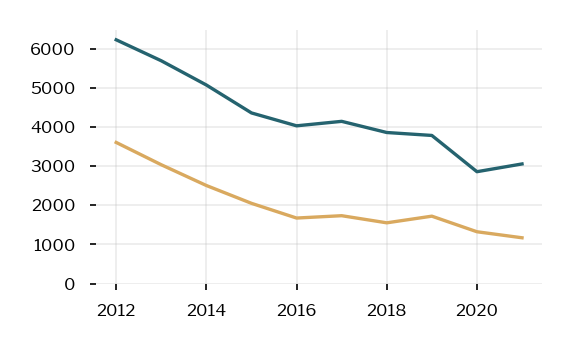

In [53]:
admissions_per_fiscal_year[["powder", "crack"]].plot()
# add_legend()
plt.legend().remove()
plt.ylim([0, None])
plt.xlabel("")
# plt.title("Prison Admissions per Fiscal Year")

In [23]:
sentence_data.head()

,total_sentence_months,primary_crime_type,NWSTAT1,NWSTAT2,NWSTAT3,NWSTAT4,NWSTAT5,DRUGMIN,WGT1,drug_type,sentencing_district,race_or_ethnicity,sentence_start_month,estimated_release_date,fiscal_year
0,151.0,Drug Trafficking,21841A1,21841B1C,NaN,NaN,NaN,0,111.9,powder,Florida,Black,2020-10-01,2033-04-30,2020
1,84.0,Drug Trafficking,21846,21841,NaN,NaN,NaN,0,1000.0,powder,Maryland,Black,2020-10-01,2027-09-30,2020
2,135.0,Drug Trafficking,21963,21960B1B,NaN,NaN,NaN,120,NaN,powder,Texas,Hispanic,2020-10-01,2031-12-31,2020
3,108.0,Drug Trafficking,21841A1,21841B1A,21841B1C,NaN,NaN,60,19217.7,powder,South Carolina,Black,2020-10-01,2029-09-30,2020
4,132.0,Drug Trafficking,21841A1,18924C,NaN,NaN,NaN,0,335.0,crack,Kentucky,Other,2020-10-01,2031-09-30,2020


In [35]:
(
    admissions_per_fiscal_year.loc[2012] - admissions_per_fiscal_year.loc[2021]
) / admissions_per_fiscal_year.loc[2012]

drug_type
crack     0.675451
powder    0.509234
dtype: float64

In [36]:
admissions_per_fiscal_year.loc[[2019, 2020, 2021]].mean()

drug_type
crack     1405.333333
powder    3232.666667
dtype: float64

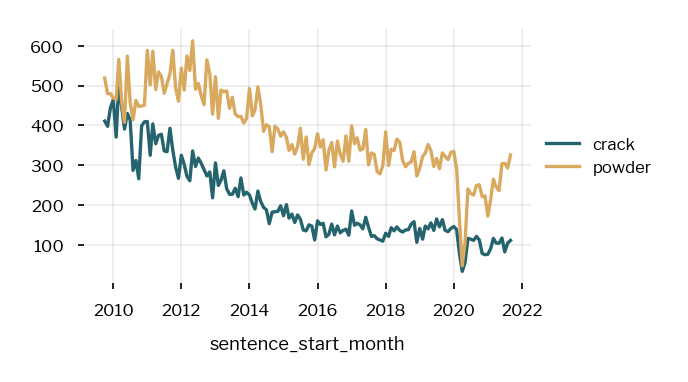

In [16]:
sentence_data.groupby(["drug_type", "sentence_start_month"]).count()[
    "total_sentence_months"
].unstack("drug_type").plot()
add_legend()

In [44]:
## Infer the `WGT1` drug weight value from the `
mm_to_weight_map = {
    "crack": {0: 0, 12: 0, 60: 28, 120: 280, 240: 5000},
    "powder": {0: 0, 12: 0, 60: 500, 120: 5000, 240: 5000, 300: 5000},
}


def infer_weight(row):
    if np.isnan(row["WGT1"]):
        return mm_to_weight_map[row["drug_type"]].get(row["DRUGMIN"], 0)
    else:
        return row["WGT1"]


sentence_data["inferred_weight"] = sentence_data.apply(infer_weight, axis=1)
sentence_data["inferred_weight"].describe()

count    8.455600e+04
mean     2.806916e+05
std      5.011237e+07
min      0.000000e+00
25%      4.000000e+01
50%      5.000000e+02
75%      5.000000e+03
max      1.452748e+10
Name: inferred_weight, dtype: float64

In [45]:
sentence_data["primary_crime_type"].value_counts(dropna=False)

Drug Trafficking                         76496
Firearms                                  4583
Drug Communication Facilities              936
Extortion/Racketeering                     853
Money Laundering                           485
Administration of Justice                  443
Drug Possession                            245
Murder                                     215
Assault                                     72
Traffic Violations and Other Offenses       54
Other                                       49
Robbery                                     38
Immigration                                 24
Fraud                                       24
Sexual Abuse                                16
Kidnapping                                  10
Prison Offenses                              8
Civil Rights Offenses                        3
Commercialized Vice                          2
Name: primary_crime_type, dtype: int64

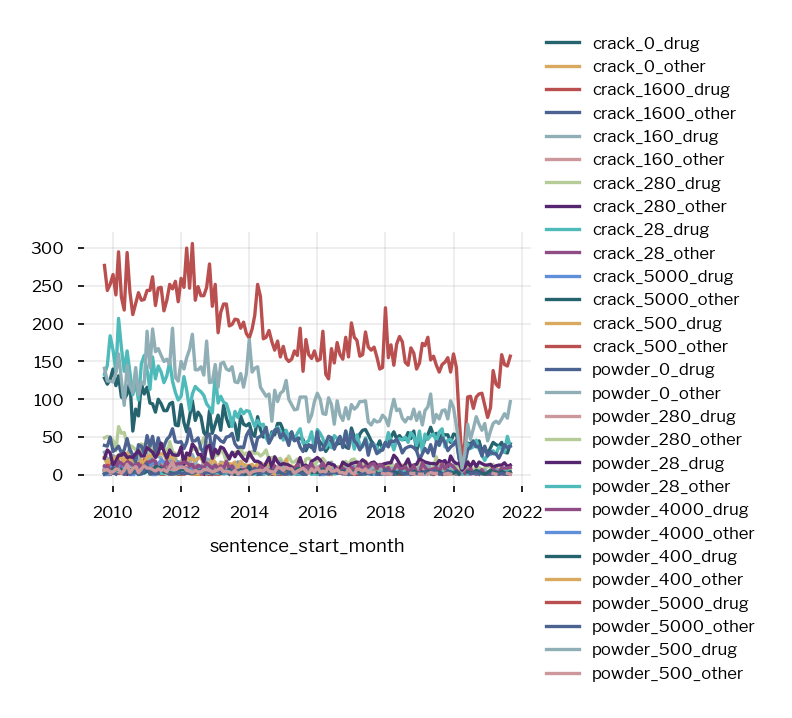

In [46]:
# Add a row for crime_type that differentiates the different groups that each policy will impact
crack_weight_range = np.array([0, 28, 160, 280, 500, 1600, 5000])
powder_weight_range = np.array([0, 28, 280, 400, 500, 4000, 5000])

# Categorize more severe offenses that aren't primarily drug-related in a separate group
# since those have different sentence length distributions
primary_crime_type_map = {
    "Firearms": "other",
    "Murder": "other",
    "Assault": "other",
    "Robbery": "other",
    "Kidnapping": "other",
    "Sexual Abuse": "other",
}


def add_crime_type_column(row):
    """Add the column to be used for the simulation `crime_type` aggregation axes"""
    if row["drug_type"] == "crack":
        weight_class = crack_weight_range[
            np.where(crack_weight_range <= row["inferred_weight"])
        ].max()
    elif row["drug_type"] == "powder":
        weight_class = powder_weight_range[
            np.where(powder_weight_range <= row["inferred_weight"])
        ].max()
    else:
        raise ValueError(f"Unsupported drug type {row['drug_type']}")

    #     return f"{row['drug_type']}_{weight_class}"
    return f"{row['drug_type']}_{weight_class}_{row['primary_crime_type_category']}"


sentence_data["primary_crime_type_category"] = sentence_data[
    "primary_crime_type"
].apply(lambda x: primary_crime_type_map.get(x, "drug"))
sentence_data["crime_type"] = sentence_data.apply(add_crime_type_column, axis=1)
sentence_data.groupby(["sentence_start_month", "crime_type"]).count()[
    "primary_crime_type"
].unstack("crime_type").plot()
add_legend()

In [47]:
sentence_data.groupby(["sentence_start_month", "crime_type"]).count()[
    "primary_crime_type"
].unstack("crime_type").tail(5)

crime_type,crack_0_drug,crack_0_other,crack_1600_drug,crack_1600_other,crack_160_drug,crack_160_other,crack_280_drug,crack_280_other,crack_28_drug,crack_28_other,crack_5000_drug,crack_5000_other,crack_500_drug,crack_500_other,powder_0_drug,powder_0_other,powder_280_drug,powder_280_other,powder_28_drug,powder_28_other,powder_4000_drug,powder_4000_other,powder_400_drug,powder_400_other,powder_5000_drug,powder_5000_other,powder_500_drug,powder_500_other
sentence_start_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-01,38.0,6.0,NaN,NaN,7.0,NaN,5.0,1.0,37.0,6.0,2.0,NaN,2.0,NaN,22.0,6.0,1.0,NaN,13.0,3.0,4.0,NaN,1.0,1.0,116.0,1.0,68.0,NaN
2021-06-01,43.0,10.0,1.0,NaN,6.0,NaN,11.0,1.0,35.0,2.0,6.0,NaN,2.0,NaN,30.0,4.0,1.0,NaN,13.0,4.0,9.0,NaN,5.0,NaN,159.0,2.0,74.0,3.0
2021-07-01,30.0,5.0,1.0,NaN,1.0,NaN,4.0,1.0,30.0,3.0,3.0,NaN,4.0,NaN,40.0,6.0,1.0,NaN,16.0,2.0,9.0,NaN,3.0,NaN,146.0,1.0,81.0,NaN
2021-08-01,29.0,4.0,2.0,NaN,5.0,NaN,8.0,NaN,51.0,1.0,NaN,NaN,4.0,NaN,36.0,3.0,4.0,NaN,11.0,6.0,9.0,NaN,2.0,NaN,144.0,1.0,75.0,2.0
2021-09-01,41.0,12.0,2.0,1.0,2.0,NaN,8.0,NaN,38.0,1.0,2.0,NaN,4.0,NaN,38.0,4.0,2.0,NaN,13.0,NaN,10.0,NaN,4.0,NaN,157.0,NaN,97.0,1.0


In [48]:
def add_mm(row, crack_limits, powder_limits):
    """Return the mandatory minimum prison length defined by the weight limits"""
    if row["drug_type"] == "crack":
        if row["inferred_weight"] < crack_limits[0]:
            return 0
        elif row["inferred_weight"] < crack_limits[1]:
            return 5
        else:
            return 10
    elif row["drug_type"] == "powder":
        if row["inferred_weight"] < powder_limits[0]:
            return 0
        elif row["inferred_weight"] < powder_limits[1]:
            return 5
        else:
            return 10
    else:
        raise ValueError(f"Unsupported drug type {row['drug_type']}")


sentence_data["baseline_mm"] = sentence_data.apply(
    partial(add_mm, crack_limits=[28, 280], powder_limits=[500, 5000]), axis=1
)
sentence_data["equal_act_mm"] = sentence_data.apply(
    partial(add_mm, crack_limits=[500, 5000], powder_limits=[500, 5000]), axis=1
)
sentence_data["smart_act_mm"] = sentence_data.apply(
    partial(add_mm, crack_limits=[160, 1600], powder_limits=[400, 4000]), axis=1
)
sentence_data["equal_enforcement_act_mm"] = sentence_data.apply(
    partial(add_mm, crack_limits=[28, 280], powder_limits=[28, 280]), axis=1
)
sentence_data["baseline_mm"].value_counts(dropna=False)

10    33494
5     29750
0     21312
Name: baseline_mm, dtype: int64

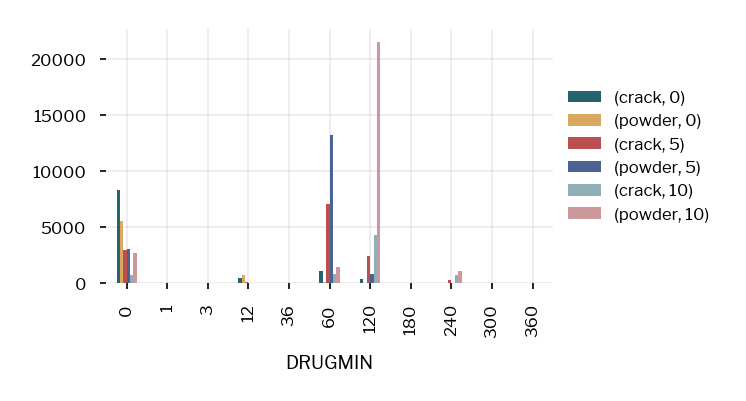

In [246]:
sentence_data.groupby(["baseline_mm", "drug_type", "DRUGMIN"]).count()[
    "primary_crime_type"
].unstack(["drug_type", "baseline_mm"]).plot.bar()
add_legend()

In [247]:
yaml_file_path = (
    "../../../state/FED/cocaine_sentencing_2021/fed_equal_act_2021_model_inputs.yaml"
)
simulation_config = YAMLDict.from_path(yaml_file_path)

# Variables used in the upload step
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Time variables used to convert to relative time steps
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [261]:
# Admissions (outflows)
monthly_admissions = (
    sentence_data.groupby(["sentence_start_month", "crime_type"])
    .count()["primary_crime_type"]
    .reset_index(drop=False)
)
monthly_admissions["compartment"] = "pretrial"
monthly_admissions["outflow_to"] = "prison"
monthly_admissions["sentence_start_month"] = pd.to_datetime(
    monthly_admissions["sentence_start_month"]
)
monthly_admissions["time_step"] = monthly_admissions["sentence_start_month"].apply(
    time_converter.convert_timestamp_to_time_step
)
monthly_admissions = monthly_admissions.rename(
    {"primary_crime_type": "total_population"}, axis=1
)
monthly_admissions.drop(["sentence_start_month"], axis=1, inplace=True)

# Remove recidivism admissions
# Recidivism (rearrest) is tracked for 8 years here: https://www.ussc.gov/research/research-reports/recidivism-among-federal-drug-trafficking-offenders
crack_admissions = monthly_admissions["crime_type"].str.contains("crack")
monthly_admissions.loc[crack_admissions, "total_population"] *= 1 - 0.294

powder_admissions = monthly_admissions["crime_type"].str.contains("powder")
monthly_admissions.loc[powder_admissions, "total_population"] *= 1 - 0.185

# monthly_admissions = monthly_admissions.set_index(
#     ["time_step", "crime_type", "compartment", "outflow_to"]
# ).unstack("crime_type")[["total_population"]].rolling(3).mean().stack("crime_type").reset_index(drop=False)
monthly_admissions.tail()

,crime_type,total_population,compartment,outflow_to,time_step
3119,powder_4000_drug,8.150,pretrial,prison,0
3120,powder_400_drug,3.260,pretrial,prison,0
3121,powder_5000_drug,127.955,pretrial,prison,0
3122,powder_500_drug,79.055,pretrial,prison,0
3123,powder_500_other,0.815,pretrial,prison,0


Text(0.0, 1.0, 'FED EQUAL Act Admissions per Month')

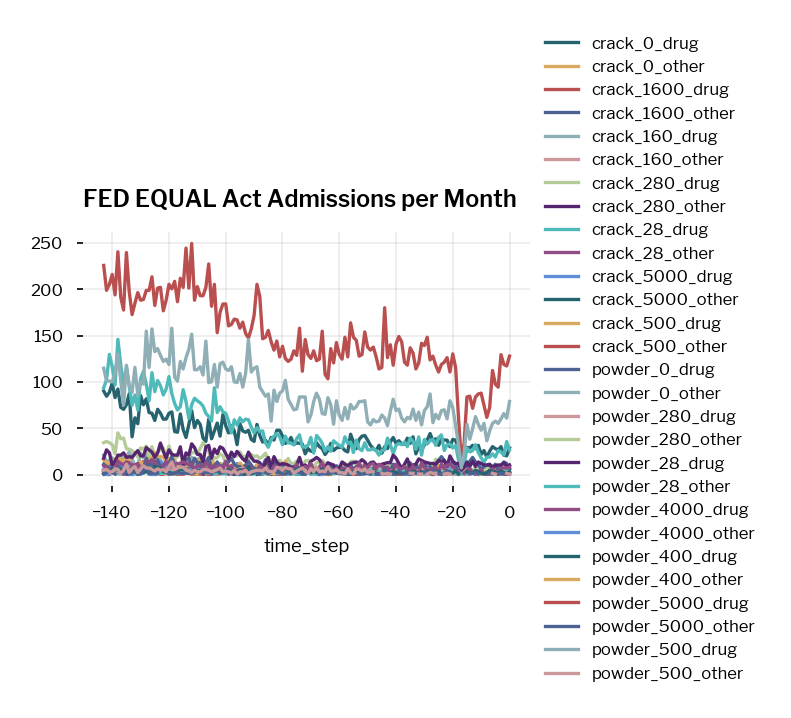

In [262]:
monthly_admissions.set_index(["time_step", "crime_type"]).unstack("crime_type")[
    "total_population"
].plot()
add_legend()
plt.title("FED EQUAL Act Admissions per Month")

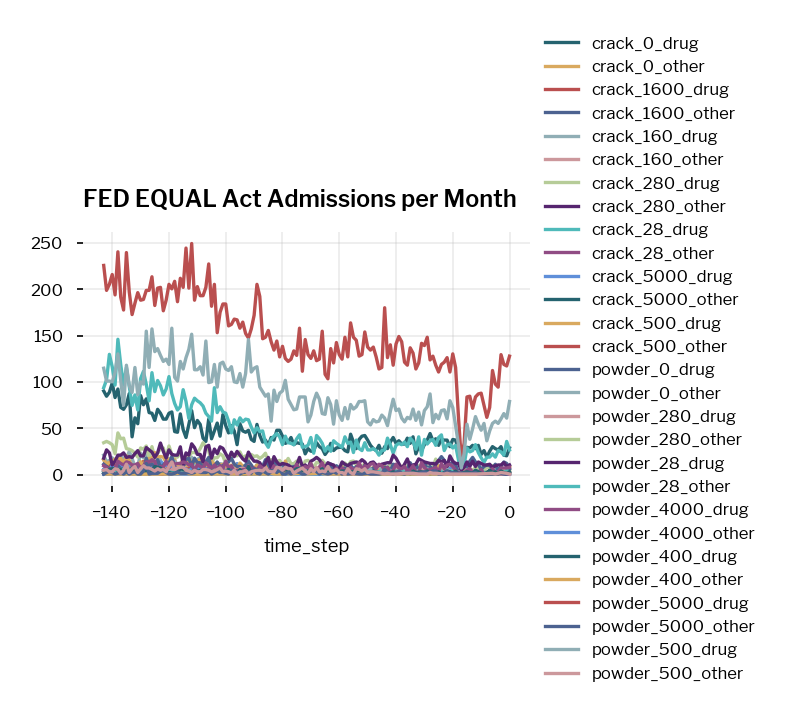

In [263]:
for crime_type, group in monthly_admissions.groupby("crime_type"):
    if crime_type == "powder_0":
        plt.figure()
    group.set_index("time_step")["total_population"].plot(label=crime_type)
    add_legend()
    plt.title("FED EQUAL Act Admissions per Month")

In [264]:
# Total population
monthly_population = pd.DataFrame(columns=sentence_data["crime_type"].unique())
monthly_population.index.name = "time_step"
for report_date in pd.date_range(
    datetime.date(2017, 1, 1), datetime.date(2021, 9, 1), freq="MS"
):
    estimated_population = sentence_data[
        (sentence_data["sentence_start_month"] < report_date.date())
        & (report_date.date() < sentence_data["estimated_release_date"])
    ]
    monthly_population.loc[report_date] = estimated_population.groupby(
        "crime_type"
    ).count()["primary_crime_type"]

monthly_population = pd.melt(
    monthly_population.reset_index(drop=False),
    id_vars=["time_step"],
    value_vars=monthly_population.columns,
    var_name="crime_type",
    value_name="total_population",
)
monthly_population["compartment"] = "prison"
monthly_population["time_step"] = monthly_population["time_step"].apply(
    time_converter.convert_timestamp_to_time_step
)
monthly_population["total_population"] = monthly_population["total_population"].astype(
    float
)
monthly_population.tail()

,time_step,crime_type,total_population,compartment
1591,-4,crack_160_other,54.0,prison
1592,-3,crack_160_other,54.0,prison
1593,-2,crack_160_other,54.0,prison
1594,-1,crack_160_other,54.0,prison
1595,0,crack_160_other,54.0,prison


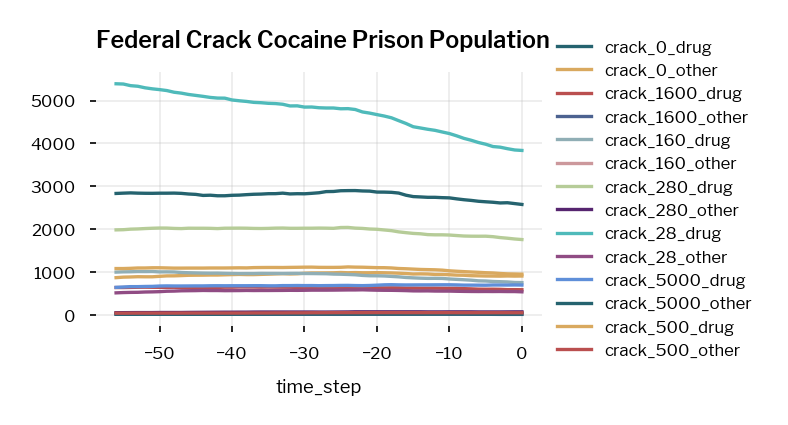

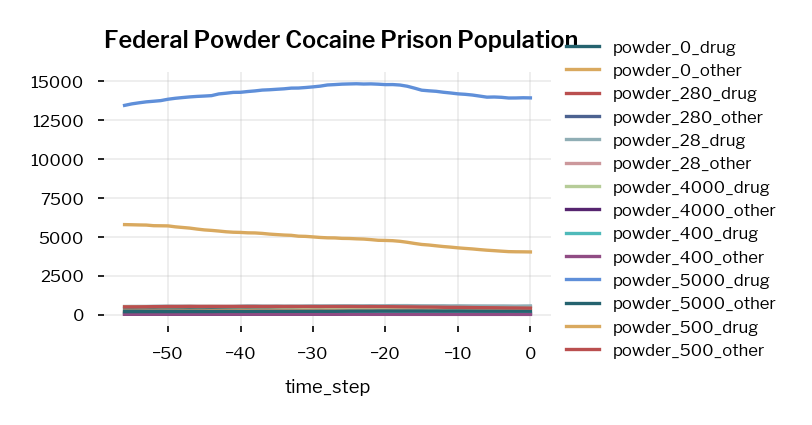

In [265]:
for drug_type in ["crack", "powder"]:
    group = monthly_population[monthly_population["crime_type"].str.contains(drug_type)]
    group.set_index(["time_step", "crime_type"]).unstack("crime_type")[
        "total_population"
    ].plot()
    add_legend()
    plt.title(f"Federal {drug_type.title()} Cocaine Prison Population")

In [266]:
# Baseline Prison Transitions
# Aggregate the total sentence distribution by the drug type & mm group and apply to all "crime type" groups

# BJS 2016 Federal Justice Statistics, Table 8.3 (https://bjs.ojp.gov/content/pub/pdf/fjs16st.pdf)
AVG_PERCENT_SERVED = 0.883

# Only use sentences from the last 4 years for the transition data (FY18-FY21)
recent_sentences = sentence_data[
    (sentence_data["sentence_start_month"] > datetime.date(2017, 9, 1))
    & (sentence_data["total_sentence_months"] > 0)
].copy()
recent_sentences["compartment_duration"] = np.clip(
    np.ceil(recent_sentences["total_sentence_months"] * AVG_PERCENT_SERVED),
    a_min=0,
    a_max=12 * 20,
)
baseline_transitions = pd.DataFrame()
for (drug_type, mm, primary_crime_type), group in recent_sentences.groupby(
    ["drug_type", "baseline_mm", "primary_crime_type_category"]
):
    # for (drug_type, mm), group in recent_sentences.groupby(["drug_type", "baseline_mm"]):
    transition_df = group.groupby("compartment_duration").count()[
        "total_sentence_months"
    ]
    transition_df /= sum(transition_df)
    for crime_type in group["crime_type"].unique():
        crime_type_transitions = transition_df.reset_index(drop=False)
        crime_type_transitions["crime_type"] = crime_type
        crime_type_transitions["compartment"] = "prison"
        crime_type_transitions["outflow_to"] = "release"
        baseline_transitions = pd.concat([baseline_transitions, crime_type_transitions])
# baseline_transitions = baseline_transitions.rename({
#     "total_sentence_months": "total_population",
#     "total_sentence_months": "compartment_duration"}, axis=1
# )
baseline_transitions = baseline_transitions.rename(
    {"total_sentence_months": "total_population"}, axis=1
)

In [267]:
baseline_transitions

,compartment_duration,total_population,crime_type,compartment,outflow_to
0,3.0,0.002185,crack_0_drug,prison,release
1,4.0,0.001092,crack_0_drug,prison,release
2,5.0,0.002185,crack_0_drug,prison,release
3,6.0,0.008738,crack_0_drug,prison,release
4,7.0,0.002185,crack_0_drug,prison,release
...,...,...,...,...,...
27,219.0,0.013889,powder_5000_other,prison,release
28,225.0,0.013889,powder_5000_other,prison,release
29,232.0,0.013889,powder_5000_other,prison,release
30,234.0,0.013889,powder_5000_other,prison,release


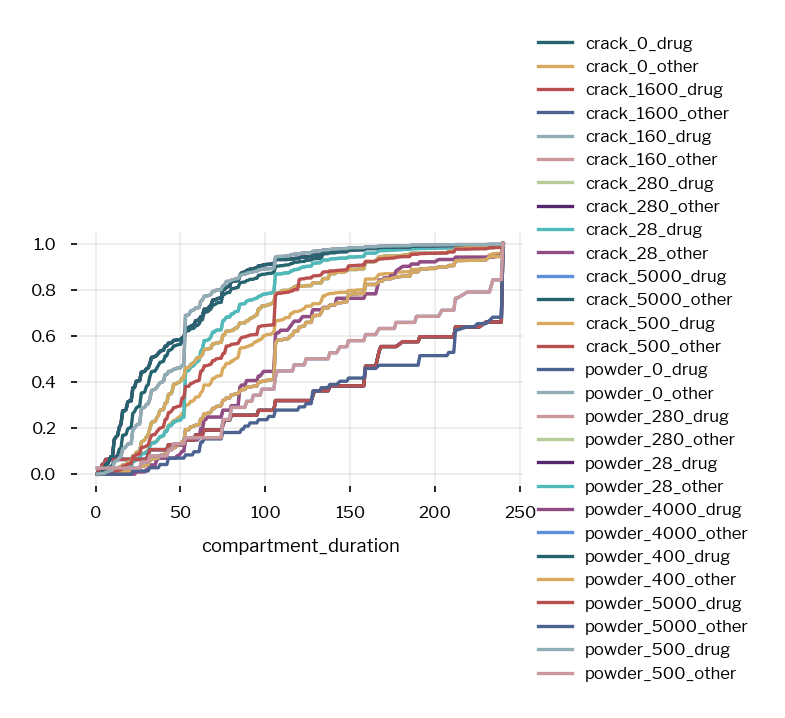

In [268]:
baseline_transitions.set_index(["compartment_duration", "crime_type"]).unstack(
    "crime_type"
)["total_population"].fillna(0).cumsum().plot()
add_legend()

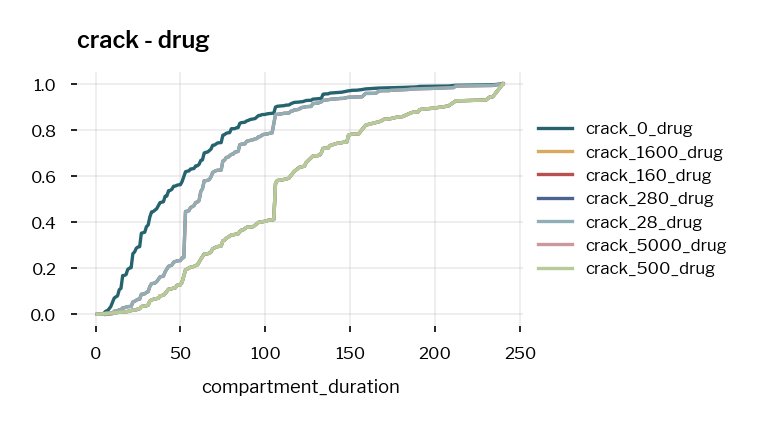

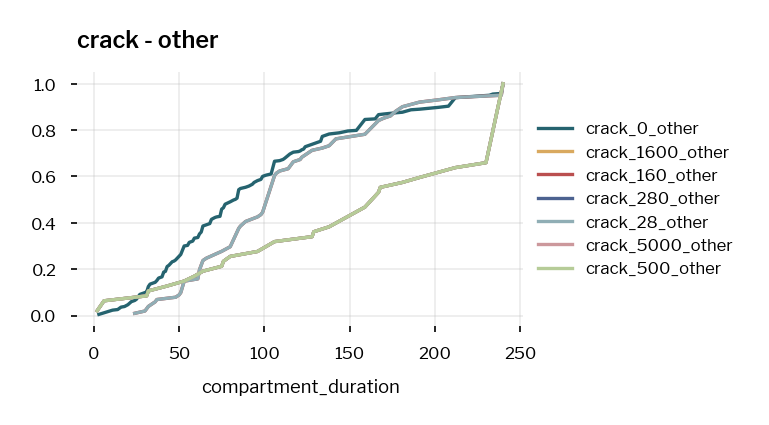

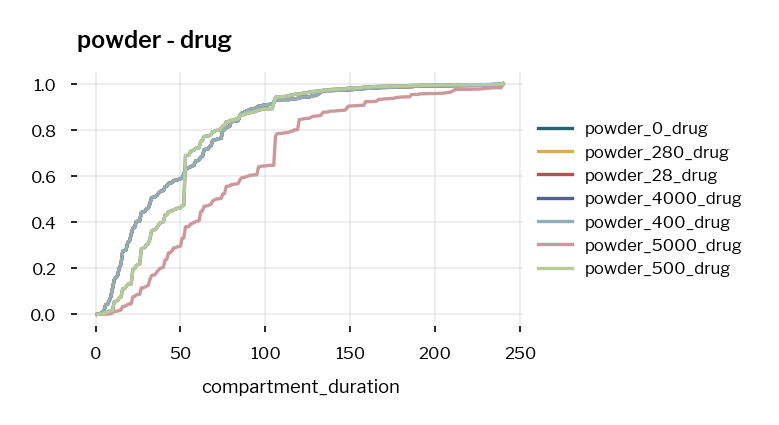

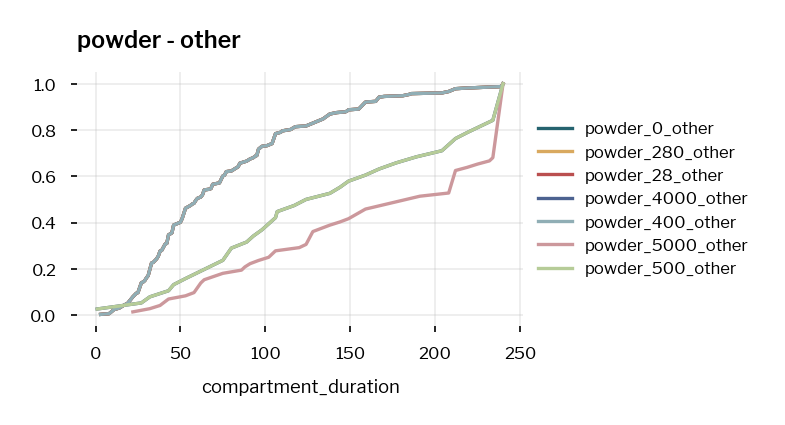

In [269]:
for drug_type in ["crack", "powder"]:
    for crime_category in ["drug", "other"]:
        group = baseline_transitions[
            baseline_transitions["crime_type"].str.contains(drug_type)
            & baseline_transitions["crime_type"].str.contains(crime_category)
        ]
        plt.figure()
        for crime_type, sub_group in group.groupby("crime_type"):
            sub_group.set_index("compartment_duration").sort_index()[
                "total_population"
            ].cumsum().plot(label=crime_type)

        add_legend()
        plt.title(f"{drug_type} - {crime_category}")

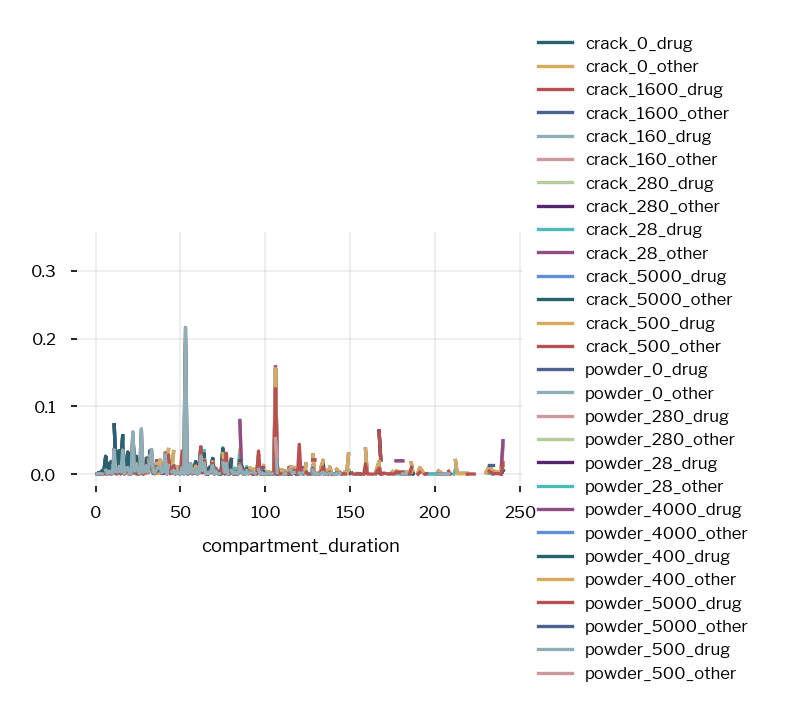

In [270]:
baseline_transitions.set_index(["compartment_duration", "crime_type"]).unstack(
    "crime_type"
)["total_population"].plot()
add_legend()

crack_reconviction_rate     0.294
powder_reconviction_rate    0.185
dtype: float64


/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/state/FED/cocaine_sentencing_2021/../../../../../../../recidiviz/calculator/modeling/population_projection/utils/spark_preprocessing_utils.py:521: UserWarning: PDF not weakly decreasing.
  warn("PDF not weakly decreasing.")
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/state/FED/cocaine_sentencing_2021/../../../../../../../recidiviz/calculator/modeling/population_projection/utils/spark_preprocessing_utils.py:521: UserWarning: PDF not weakly decreasing.
  warn("PDF not weakly decreasing.")
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/state/FED/cocaine_sentencing_2021/../../../../../../../recidiviz/calculator/modeling/population_projection/utils/spark_preprocessing_utils.py:521: UserWarning: PDF not weakly decreasing.
  warn("PDF not weakly decreasing.")
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/state/FED/cocain

Text(0.0, 1.0, 'Reincarceration Transitions')

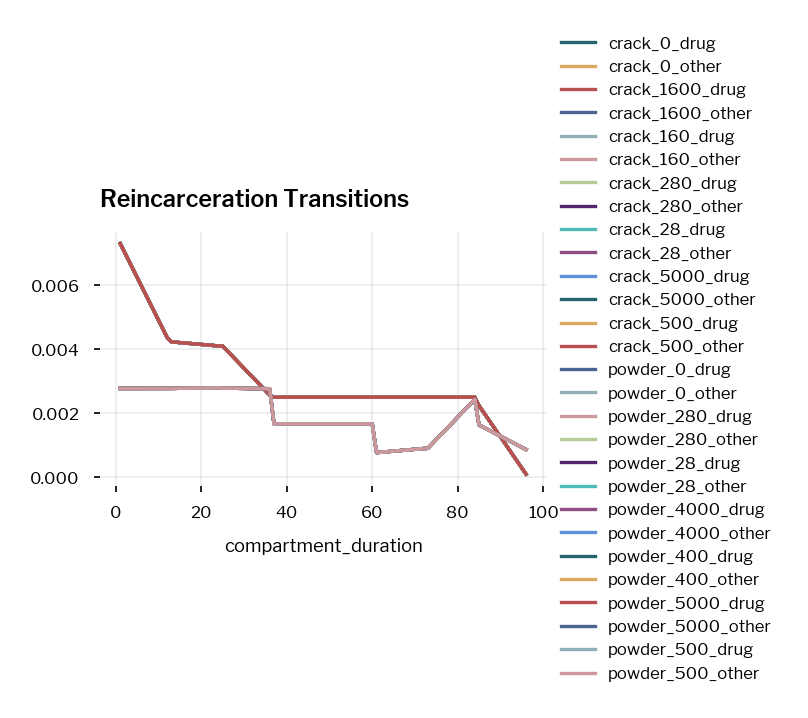

In [271]:
# Add transitions from release back to prison and to release_full
# Recidivism (rearrest) is tracked for 8 years here: https://www.ussc.gov/research/research-reports/recidivism-among-federal-drug-trafficking-offenders
# Estimating annual reincarceration amounts manually looking at graph.
# (follow up: can we do better than this with the case-level data and previous conviction data?)

reconviction_cdf = pd.DataFrame(
    {
        "crack_reconviction_rate": [0.07, 0.12, 0.16, 0.19, 0.22, 0.25, 0.28, 0.294],
        "powder_reconviction_rate": [
            0.0333,
            0.0667,
            0.1,
            0.12,
            0.14,
            0.15,
            0.17,
            0.185,
        ],
    },
    index=range(1, 9),
)
pdf = reconviction_cdf.sub(reconviction_cdf.shift().fillna(0))
print(pdf.sum())
reincarceration_transitions = pd.concat(
    [
        transitions_interpolation(
            c_from="release",
            c_to="prison",
            pdf_list=pdf[
                f"{simulation_group.split('_')[0]}_reconviction_rate"
            ].tolist(),
            disagg_label="crime_type",
            disagg_value=simulation_group,
        )
        for simulation_group in baseline_transitions["crime_type"].unique()
    ]
)
reincarceration_transitions.set_index(["compartment_duration", "crime_type"])[
    "total_population"
].unstack("crime_type").plot()
add_legend()
plt.title("Reincarceration Transitions")

In [272]:
reincarceration_transitions.head()

,compartment,outflow_to,crime_type,compartment_duration,total_population
0,release,prison,crack_0_drug,1,0.007303
1,release,prison,crack_0_drug,2,0.007036
2,release,prison,crack_0_drug,3,0.006768
3,release,prison,crack_0_drug,4,0.006501
4,release,prison,crack_0_drug,5,0.006234


In [273]:
full_release_transitions = []
for crime_type, group in reincarceration_transitions.groupby("crime_type"):
    row = {
        "compartment": "release",
        "outflow_to": "release_full",
        "crime_type": crime_type,
        "compartment_duration": 96,
        "total_population": 1 - group["total_population"].sum(),
    }
    full_release_transitions.append(row)
    # Add dummy cyclical transition for `release_full`
    release_full_row = {
        "compartment": "release_full",
        "outflow_to": "release_full",
        "crime_type": crime_type,
        "compartment_duration": 1,
        "total_population": 1,
    }
    full_release_transitions.append(release_full_row)
full_release_transitions = pd.DataFrame(full_release_transitions)
full_release_transitions

,compartment,outflow_to,crime_type,compartment_duration,total_population
0,release,release_full,crack_0_drug,96,0.706000
1,release_full,release_full,crack_0_drug,1,1.000000
2,release,release_full,crack_0_other,96,0.706000
3,release_full,release_full,crack_0_other,1,1.000000
4,release,release_full,crack_1600_drug,96,0.706000
5,release_full,release_full,crack_1600_drug,1,1.000000
6,release,release_full,crack_1600_other,96,0.706000
7,release_full,release_full,crack_1600_other,1,1.000000
8,release,release_full,crack_160_drug,96,0.706000
9,release_full,release_full,crack_160_drug,1,1.000000


In [274]:
full_transition_data = pd.concat(
    [
        baseline_transitions,
        reincarceration_transitions,
        full_release_transitions,
    ]
)

In [275]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=monthly_admissions,
    transitions_data_df=full_transition_data,
    total_population_data_df=monthly_population,
    yaml_path=yaml_file_path,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]
